In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/wave_propogation_new/wave-propagation

/content/drive/MyDrive/wave_propogation_new/wave-propagation


In [3]:

# a = torch.randn(4, 3, 2, 2)
# res = a.view(a.shape[0] * a.shape[1], -1)
# torch.norm(res, p=np.Inf, dim=1).shape

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pickle

import torch
from PIL import Image
import torchvision.transforms as transforms

# from utils import  Simulation, get_vp, ParamsGenerator

from train_utils import get_batch, train, validate#, test
from plottings import show_grig
from IPython.display import clear_output
from time import gmtime, strftime
from utils import save_model, model_best, load_model

import torch, torch.nn as nn
import torch.nn.functional as F

from models import WaveAE, WaveGRUModel, WaveLSTMModel
from losses import WaveLoss
import torch, torch.nn as nn

from torch import optim 
from plottings import plot_metrics
from utils import load_metrics
from test import testing
%load_ext autoreload
%autoreload 2

In [5]:
!pip install GPUtil

In [6]:
device = 'cpu' if not torch.cuda.is_available() else 'cuda'
device

'cuda'

In [20]:
batch_size = 8
n_epochs = 1000
# n_epochs = 400
n_batches_per_epoch = 10
n_validation_batches = 5

In [21]:


N_min = 4.
N_max = 6.

nx, nz, nt = 100, 100, 25

# model = WaveAE(in_channels=1, bottle_neck=32, n_layers=2, kernel_size=3,
#               pooling=nn.MaxPool2d, activation=nn.ELU, pruning=True)

h_control = {'ord': 'l1', 'lam': 0.}
# 
# model = WaveGRUModel(bottle_neck=32, rnn_channels=32, n_layers=2, kernel_size=3,
#                      pooling=nn.AvgPool2d, activation=nn.ELU, pruning=False, 
#                      mode='fast', hidden_control=h_control)


model = WaveLSTMModel(bottle_neck=32, rnn_channels=32, n_layers=2, kernel_size=3,
                     pooling=nn.MaxPool2d, activation=nn.ELU, pruning=False, 
                     mode='fast', hidden_control=h_control)

model.to(device)

#loss = nn.MSELoss()
#loss = nn.L1Loss()

loss = WaveLoss(order='l1', factor=None, masked=0.)

# alpha = nn.Parameter(torch.Tensor([1.]), requires_grad=True)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)#, weight_decay=1e-4)
# scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)
#add_name = 'AE/pruning_MaxPool2d_ELU'

#add_name = 'final/pruning_ELU_MaxPool2d_fast_'
#add_name = 'fast_ELU_pruning_MaxPool2d_'

add_name = 'EtoMognoUdalit'
#GPUtil.showUtilization()

In [22]:
import gc
# del batch
gc.collect()
torch.cuda.empty_cache()

#GPUtil.showUtilization()

In [23]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)#, weight_decay=1e-4)


# loss = WaveLoss(order='l1', factor=None, masked='abs')

130


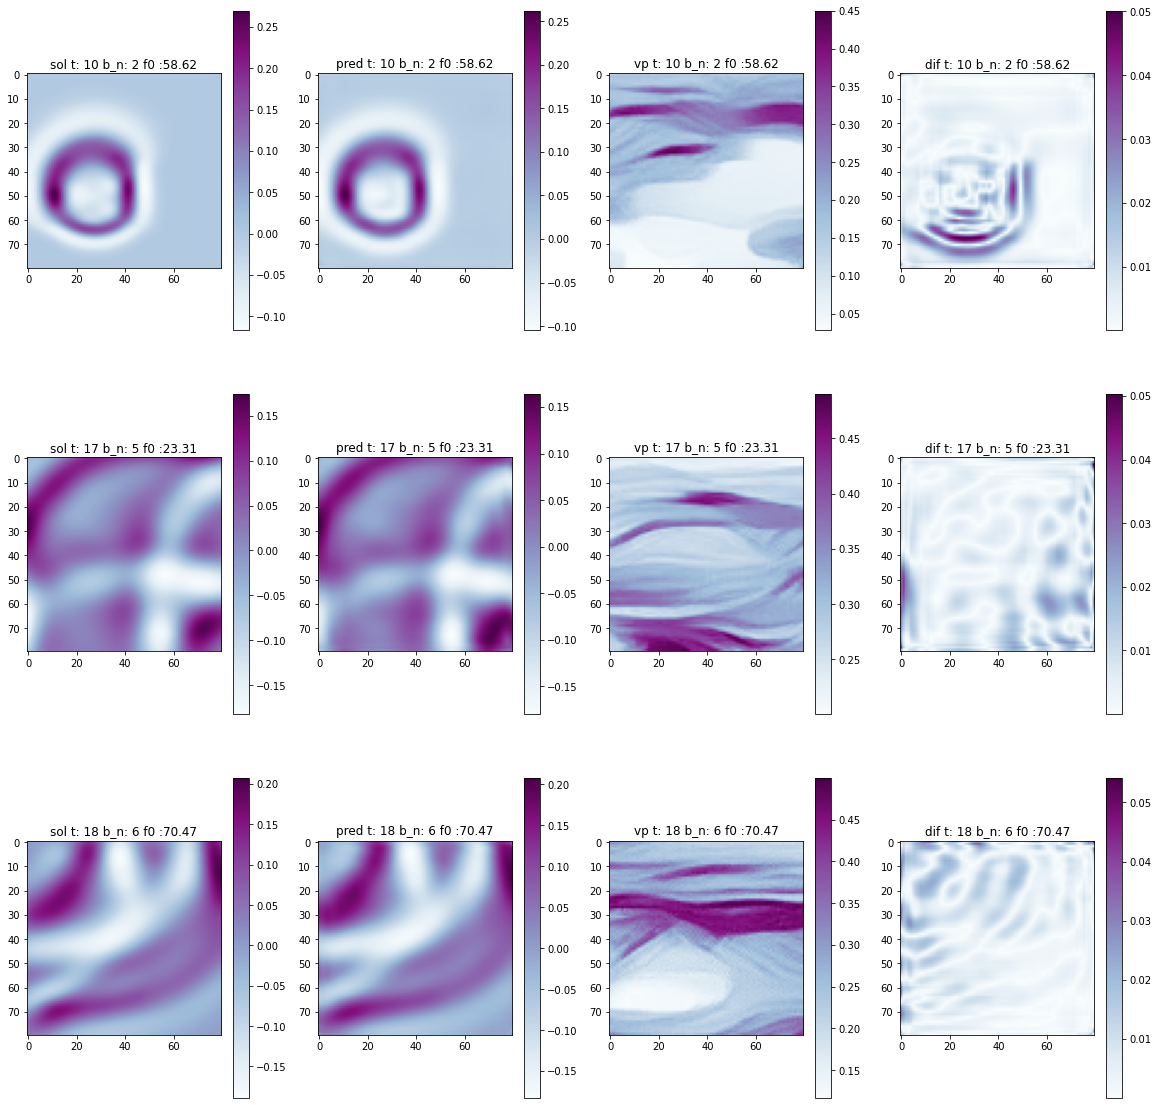



Epoch: 130, train loss: 0.00022392669197870418, val loss: 0.00023543363204225898


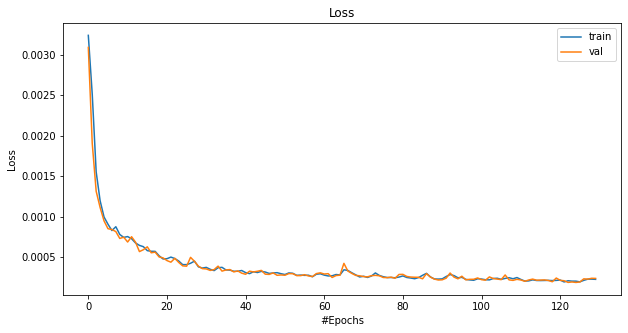

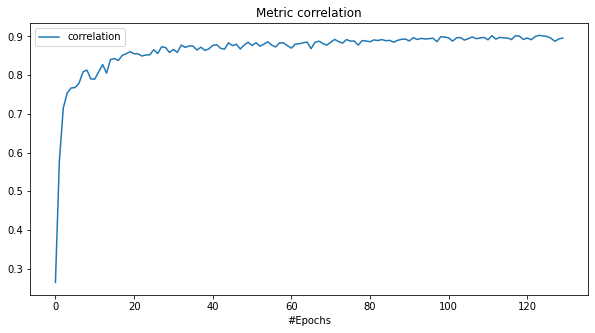

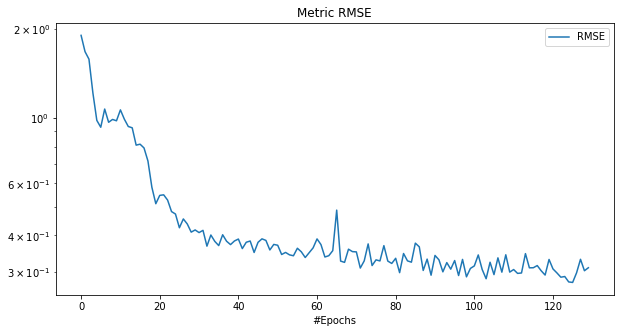

131


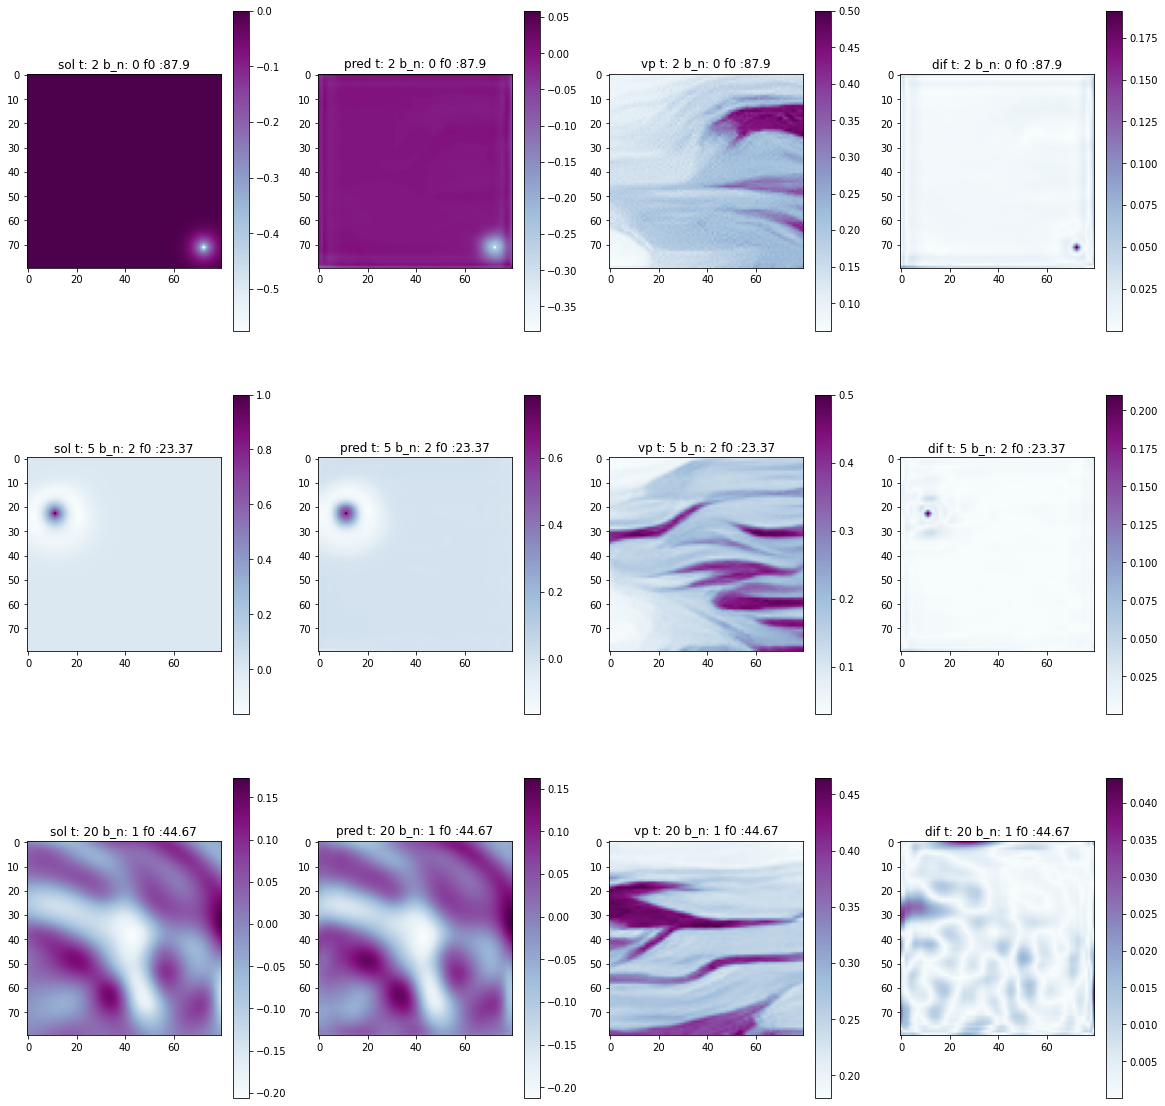



Epoch: 131, train loss: 0.00022386179043678566, val loss: 0.00019423481717240065


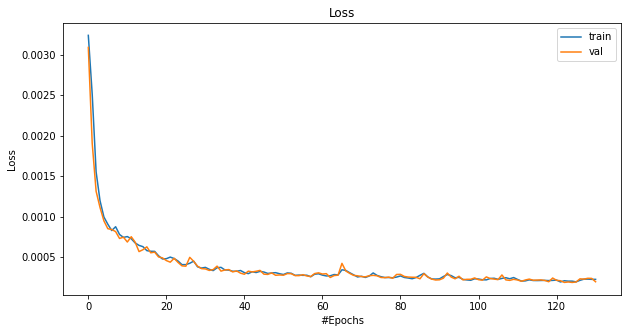

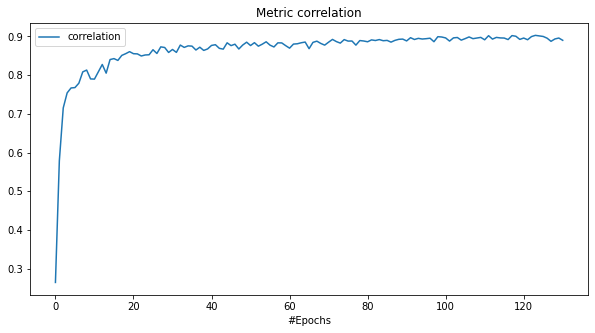

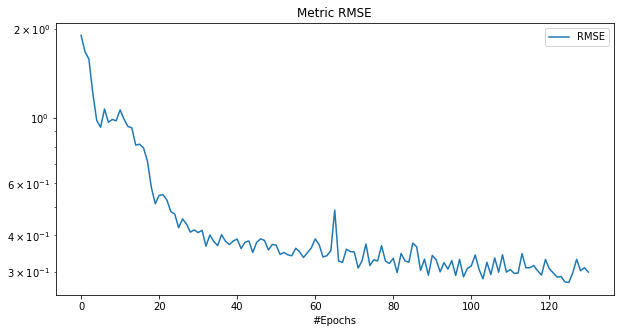

132


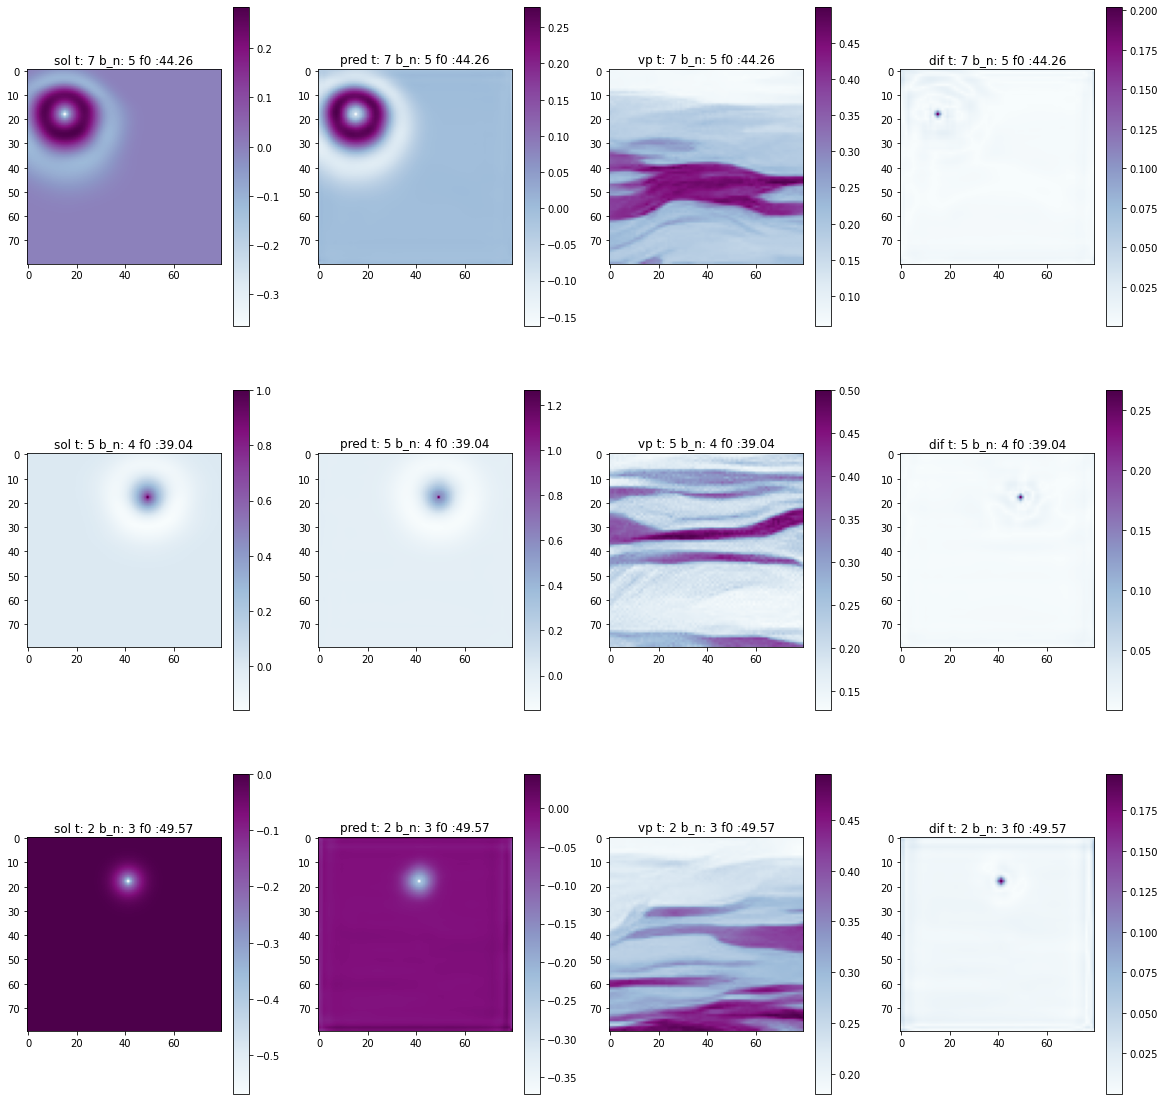



Epoch: 132, train loss: 0.00019074950541835277, val loss: 0.00020620235882233827


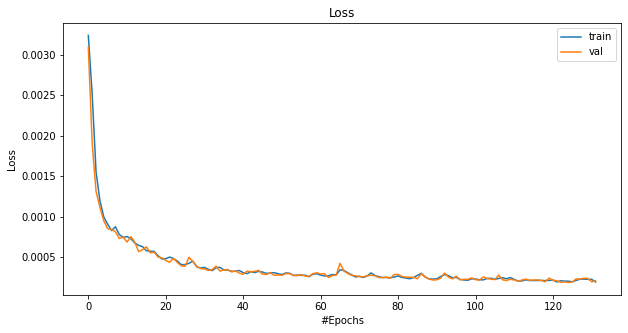

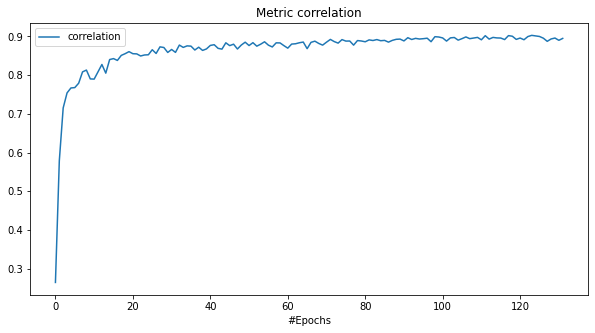

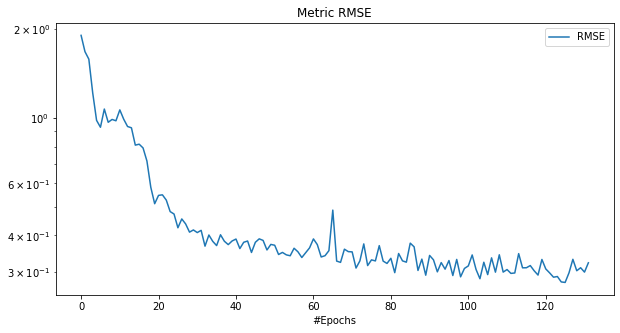

Parameters of the model and optimizer are saved to file --> ./checkpoints/EtoMognoUdalitWaveLSTMModel_best_train.pth
133


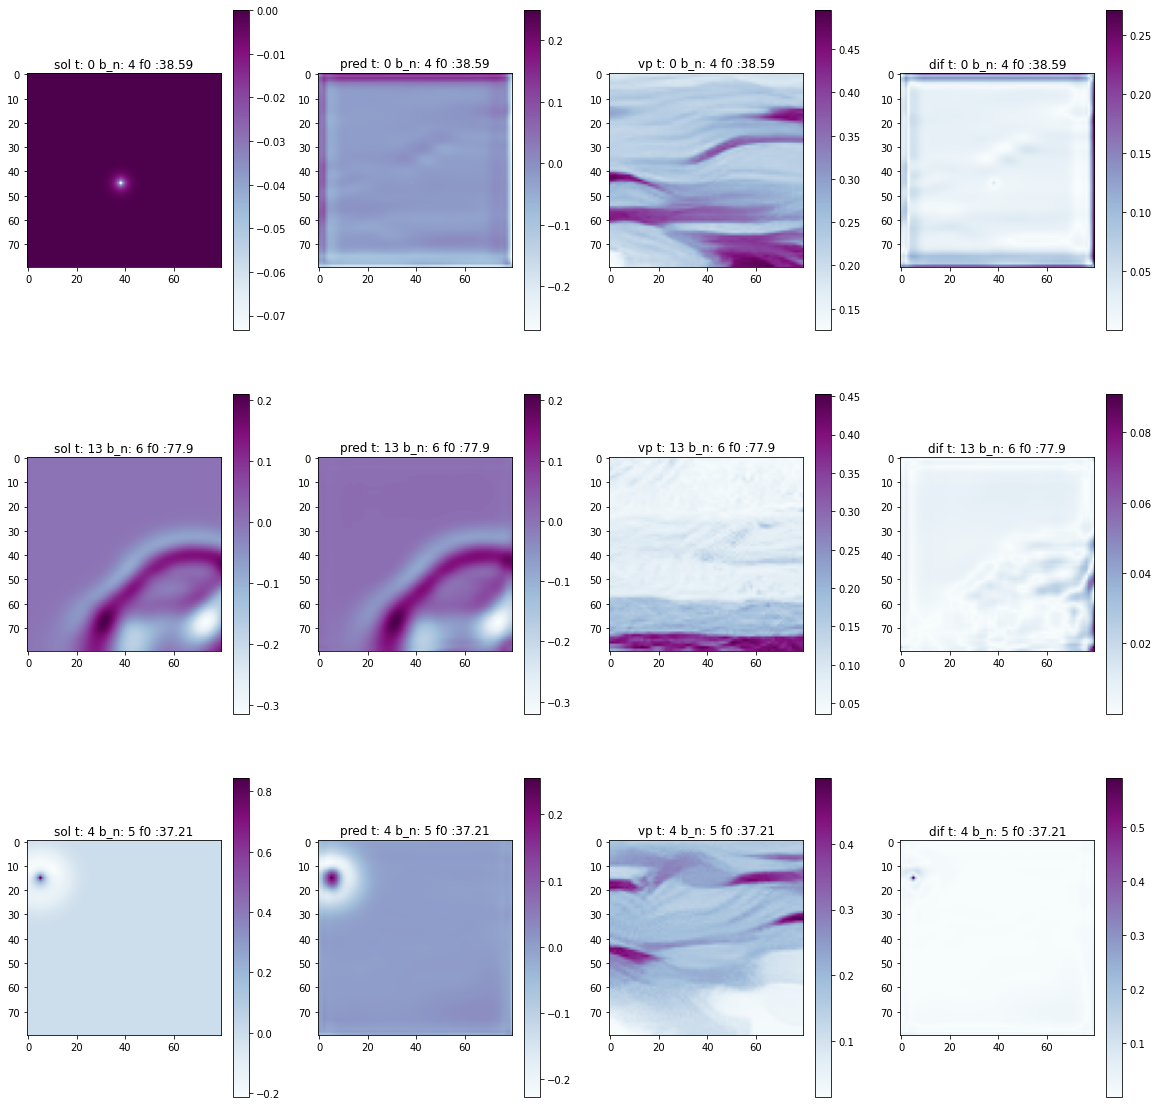




...
KeyboardInterrupt error: model saving started!
Parameters of the model and optimizer are saved to file --> ./checkpoints/EtoMognoUdalitWaveLSTMModel_KeyboardInterrupt_2020-12-20 06:12:08.pth
Parameters of the model and optimizer are saved to file --> ./checkpoints/EtoMognoUdalit_LAST_WaveLSTMModel_KeyboardInterrupt_2020-12-20 06:12:08.pth


In [24]:
from plottings import plot_metrics
loss_hist = {'train': [],
             'val': []}

metrix_coeff = {'correlation': [],
                'RMSE': []}

epoch_time_nn = []
epoch_time_fd = []

factors = []

EPOCH_t = 1

try :
  for epoch in tqdm(range(1, n_epochs + 1)):
    
    if epoch % 5 == 0:
      clear_output()
    
    print(epoch)
    # if epoch < EPOCH_t:
    train(model, optimizer, loss_hist, epoch_time_nn, N_min, N_max, nx, nz, nt,
          epoch_time_fd, n_batches_per_epoch, batch_size, device, loss)#, scheduler)
    
    validate(model, optimizer, loss_hist, n_validation_batches, 
          device, N_min, N_max, nx, nz, nt, loss, batch_size, metrix_coeff)
    # else:
    #   train(model, optimizer, loss_hist, epoch_time_nn, N_min, N_max, nx, nz, nt,
    #         epoch_time_fd, n_batches_per_epoch, batch_size, device, loss, forcing=False)
    

    #   validate(model, optimizer, loss_hist, n_validation_batches, 
    #           device, N_min, N_max, nx, nz, nt, loss, batch_size, metrix_coeff, forcing=False)
    
    # plot_metrics(model, epoch, loss_hist, epoch_time_nn, epoch_time_fd, metrix_coeff)
    plot_metrics(model, epoch, loss_hist, metrix_coeff)

    # check for best model
    result = model_best(loss_hist, metrix_coeff)
    # print(result)
    if result != []:
      # print("Yes")
      save_model(epoch, model, optimizer, loss_hist, metrix_coeff, best_names=result, KI=False, add_name=add_name)

except KeyboardInterrupt:
  print('\n\n\n...\nKeyboardInterrupt error: model saving started!')
  save_model(epoch, model, optimizer, loss_hist, metrix_coeff, best_names=[], KI=True, add_name=add_name)  

save_model(epoch, model, optimizer, loss_hist, metrix_coeff, best_names=[], KI=True, add_name=add_name+'_LAST_')

In [ ]:
# save_model(epoch, model, optimizer, loss_hist, metrix_coeff, best_names=[], KI=True, add_name=add_name+'_LAST_')

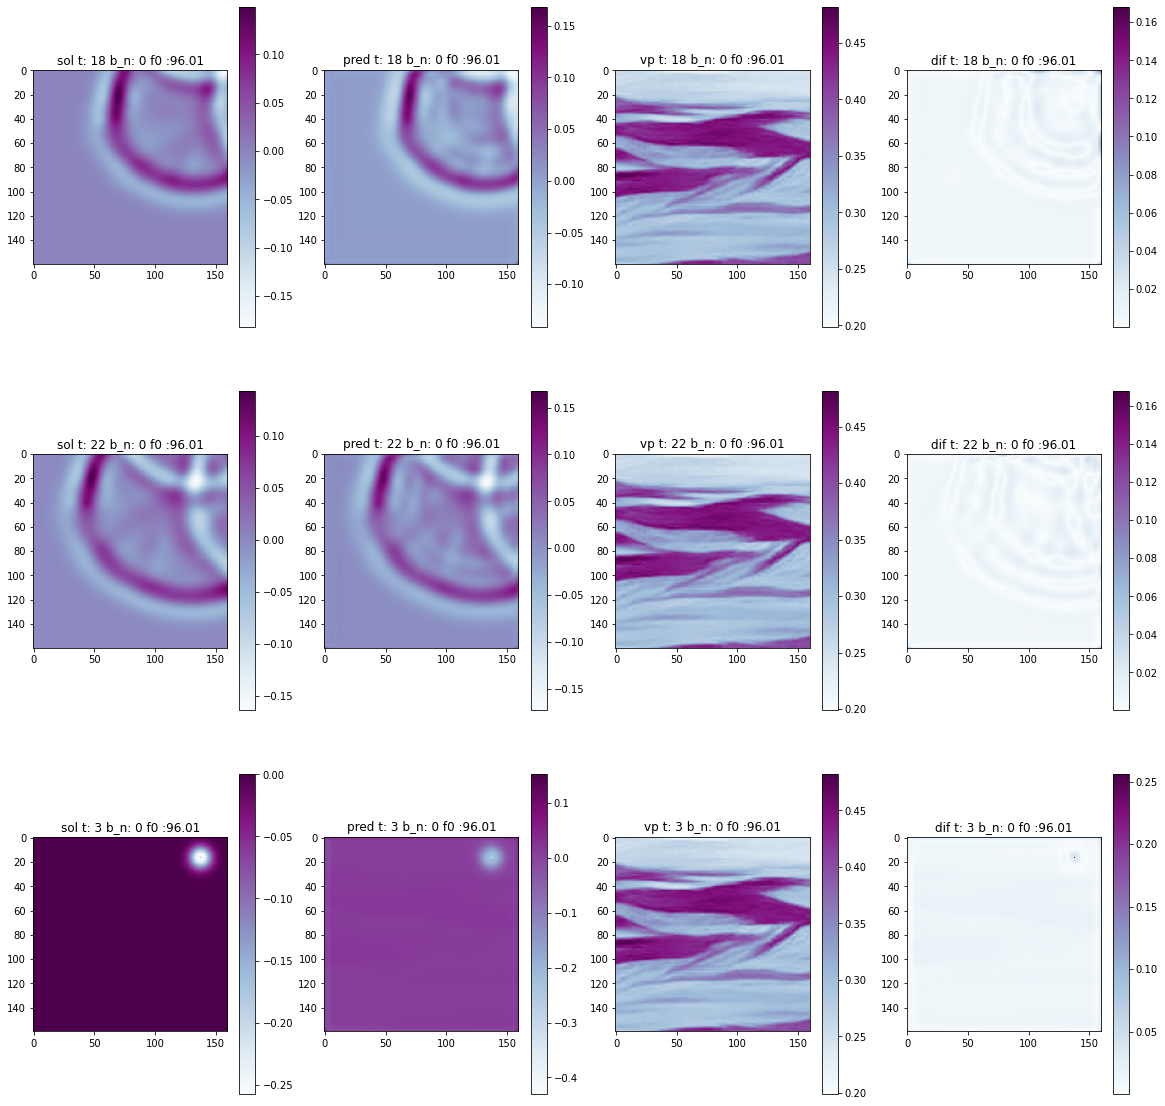

In [12]:
 validate(model.to('cpu'), optimizer, loss_hist, 1, 
          'cpu', N_min, N_max, 200, 200, 30, loss, 1, metrix_coeff)
  

In [33]:
testing_from0(model.to('cpu'), optimizer, loss_hist, 1, 
          'cpu', N_min, N_max, 200, 200, 30, loss, 1, metrix_coeff, start_nn_t=10)
  

Output hidden; open in https://colab.research.google.com to view.

In [17]:
from test import testing_from0


Epoch: 90, train loss: 0.0004122889251448214, val loss: 0.00040259447414428
(tensor(4.8611), 144, tensor([0.0132], device='cuda:0', grad_fn=<SigmoidBackward>))
(tensor(36.6970), 4608, tensor([0.0097], device='cuda:0', grad_fn=<SigmoidBackward>))
(tensor(11.8056), 144, tensor([0.0040], device='cuda:0', grad_fn=<SigmoidBackward>))
(tensor(46.9184), 4608, tensor([0.0243], device='cuda:0', grad_fn=<SigmoidBackward>))
(tensor(38.9106), 4608, tensor([0.0231], device='cuda:0', grad_fn=<SigmoidBackward>))
(tensor(3.4722), 144, tensor([0.0029], device='cuda:0', grad_fn=<SigmoidBackward>))
(tensor(77.1023), 73728, tensor([0.0199], device='cuda:0', grad_fn=<SigmoidBackward>))


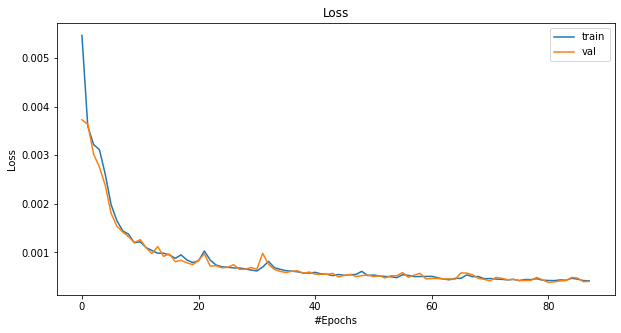

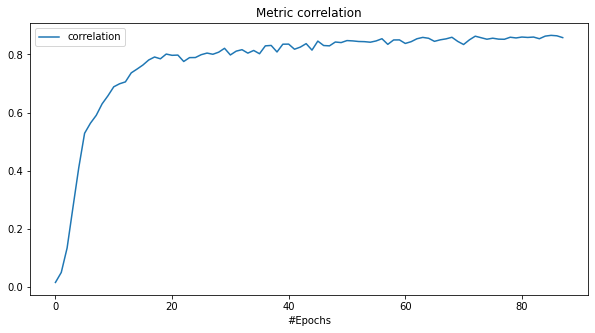

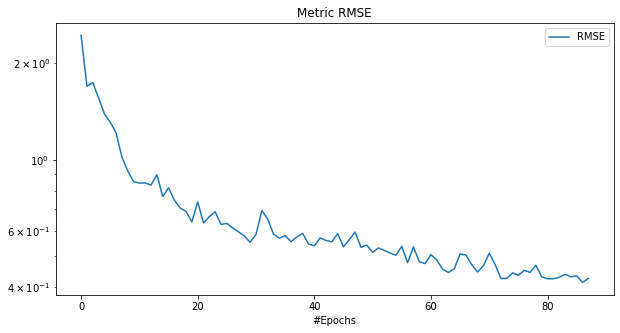

In [11]:
epoch = 5
loss_hist = {'train': [],
             'val': []}

metrix_coeff = {'metrix_coeff': [],
                'RMSE': []}

loss_hist, metrix_coeff, epoch = load_model('./checkpoints/EtoMognoUdalit_LAST_WaveLSTMModel_KeyboardInterrupt_2020-12-20 02:28:40.pth', model, optimizer, loss_hist, metrix_coeff)
plot_metrics(model, epoch, loss_hist, metrix_coeff)

In [32]:
testing(model.to('cuda'), optimizer, loss_hist, 1, 
          'cuda', N_min, N_max, 300, 300, 70, loss, 1, metrix_coeff, gif=True)
  

Output hidden; open in https://colab.research.google.com to view.

In [15]:
import imageio

In [16]:
import os


In [29]:
metrix_coeff['correlation'][-1]

0.9334965944290161

In [31]:
filenames = os.listdir('./anim')
with imageio.get_writer('./animation_4.gif', mode='I', fps=5) as writer:
    for filename in filenames:
        image = imageio.imread('./anim/'+filename)
        writer.append_data(image)

In [67]:
display(ani)


Epoch: 379, train loss: 0.19153904691338539, val loss: 0.10796433240175247
(tensor(30.5556), 144, tensor([0.0535], device='cuda:0', grad_fn=<SigmoidBackward>))
(tensor(56.8359), 4608, tensor([0.0238], device='cuda:0', grad_fn=<SigmoidBackward>))
(tensor(18.7500), 144, tensor([0.0372], device='cuda:0', grad_fn=<SigmoidBackward>))
(tensor(26.6059), 4608, tensor([0.0016], device='cuda:0', grad_fn=<SigmoidBackward>))
(tensor(32.4002), 4608, tensor([0.0052], device='cuda:0', grad_fn=<SigmoidBackward>))
(tensor(34.7222), 144, tensor([0.1018], device='cuda:0', grad_fn=<SigmoidBackward>))
(tensor(51.9911), 18432, tensor([0.0032], device='cuda:0', grad_fn=<SigmoidBackward>))
(tensor(52.0345), 18432, tensor([0.0036], device='cuda:0', grad_fn=<SigmoidBackward>))


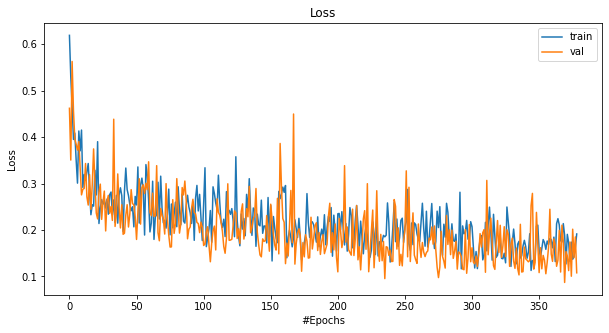

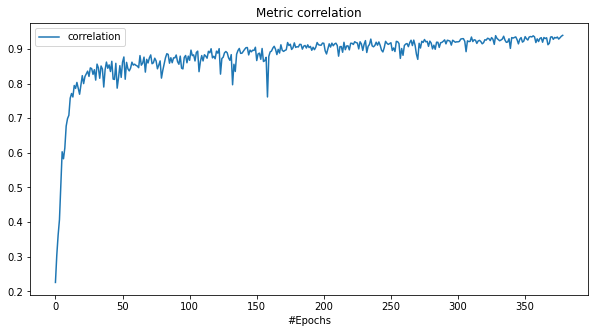

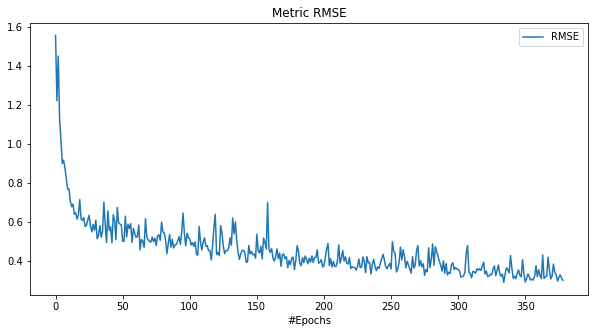

In [ ]:


plot_metrics(model, epoch, loss_hist, metrix_coeff)


Epoch: 29, train loss: 0.6958340287208558, val loss: 0.77426518201828


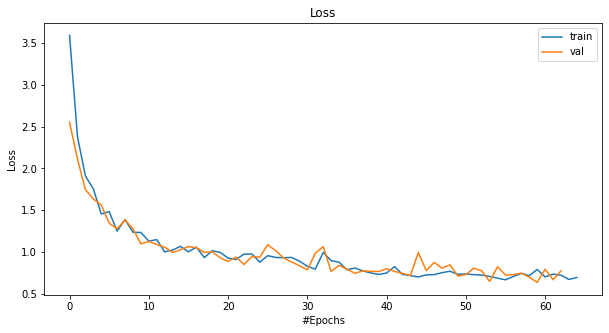

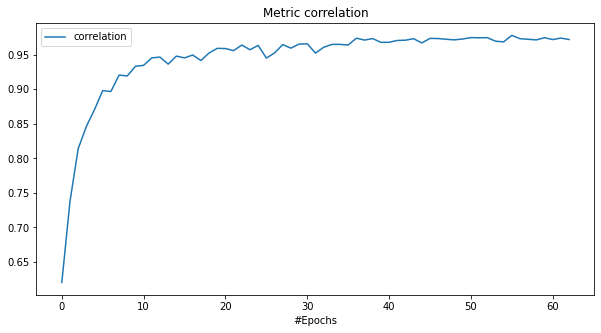

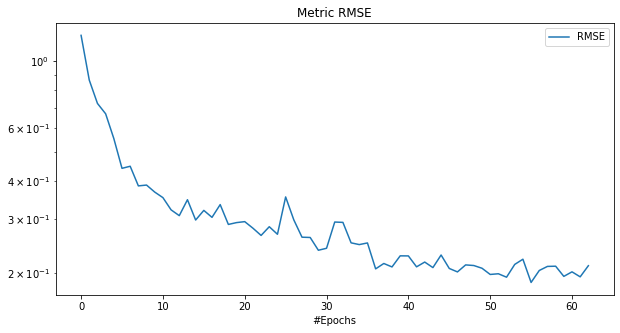

In [ ]:
############## some pictures #######################

# model = WaveAE(in_channels=1, bottle_neck=32, n_layers=2, kernel_size=3,
#               pooling=nn.MaxPool2d, activation=nn.Tanh, pruning=False)

# model = WaveGRUModel(bottle_neck=32, n_layers=2, kernel_size=3,
#                pooling=nn.MaxPool2d, activation=nn.ELU, pruning=False, mode='fooo')

# model.to(device)

#loss = nn.MSELoss()
# loss = nn.L1Loss()

# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)#, weight_decay=1e-4)

epoch = 5
loss_hist = {'train': [],
             'val': []}

metrix_coeff = {'correlation': [],
                'RMSE': []}

epoch_time_nn = [1]
epoch_time_fd = [1]


# loss_hist, metrix_coeff, epoch = load_model('./checkpoints/RNN/no_pruning_MaxPool2d_ELU_fooo__LAST_WaveGRUModel_KeyboardInterrupt_2020-11-21 21_24_30.pth', model, optimizer, loss_hist, metrix_coeff)
loss_hist, metrix_coeff, epoch = load_model('./checkpoints/LSTM_TRY_no_pruning_L1WaveLSTMModel_KeyboardInterrupt_2020-12-06 14_21_03.pth', model, optimizer, loss_hist, metrix_coeff)
plot_metrics(model, epoch, loss_hist, metrix_coeff)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


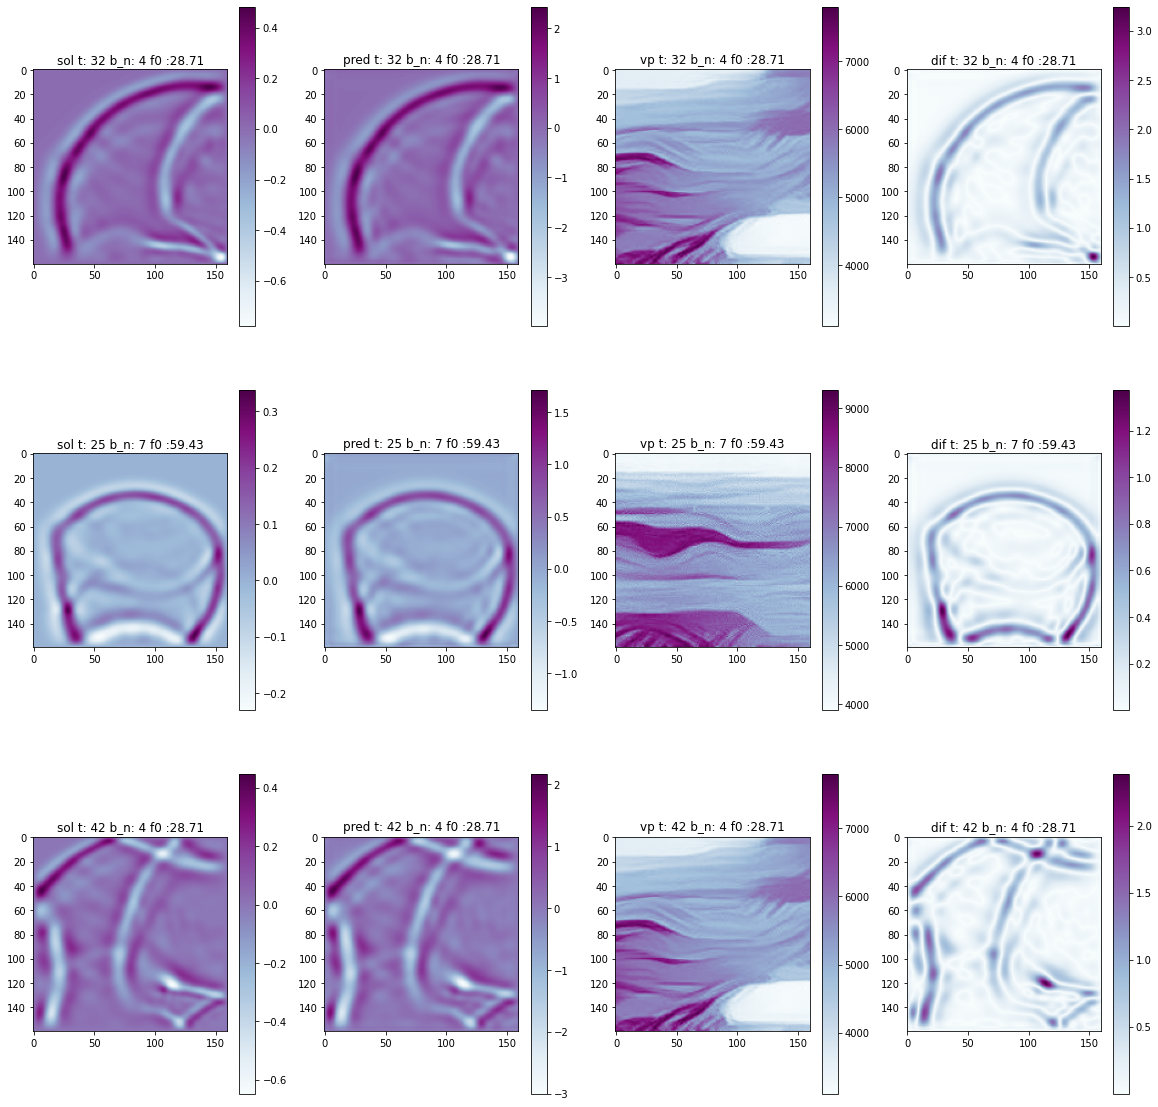

In [ ]:
validate(model, optimizer, loss_hist, n_validation_batches, 
            device, N_min, N_max, nx*2, nz*2, nt*2, loss, batch_size, metrix_coeff)

In [ ]:

from plottings import plot_test_video
from test import test_model_model, test_diff_model, test_diff_model__

In [ ]:
# #path_to_model = './checkpoints/RNN/no_pruning_MaxPool2d_ELU_fooo_WaveGRUModel_best_val_best_correlation.pth'
#  path_to_model = './checkpoints/foooooWaveGRUModel_best_correlation.pth'
# tester = Test(path_to_model, optimizer, model, device)

In [ ]:
device

'cuda'

In [ ]:
# model_1 = WaveAE(in_channels=1, bottle_neck=32, n_layers=2, kernel_size=3,
#               pooling=nn.MaxPool2d, activation=nn.ELU, pruning=True)
# path_model_1 = './checkpoints/first_3_pictures_MaxPool2d_ELU_pruning_factor_l1WaveAE_KeyboardInterrupt_2020-12-06 01:12:54.pth'


# h_control = {'ord': 'l1', 'lam': 0.}
# model_2 = WaveGRUModel(bottle_neck=32, rnn_channels=32, n_layers=2, kernel_size=3,
#                      pooling=nn.MaxPool2d, activation=nn.ELU, pruning=True, 
#                      mode='fast', hidden_control=h_control)

# path_model_2 = './checkpoints/fooo_WaveGRUModel_best_correlation.pth'

# model_1.to(device)
# model_2.to(device)

In [ ]:
# epoch = 5
# loss_hist = {'train': [],
#              'val': []}

# metrix_coeff = {'correlation': [],
#                 'RMSE': []}

# epoch_time_nn = [1]
# epoch_time_fd = [1]
# optimizer = torch.optim.Adam(model_1.parameters(), lr=1e-3)
# loss_hist, metrix_coeff, epoch = load_model(path_model_1, model_1, optimizer, loss_hist, metrix_coeff)
# loss_hist, metrix_coeff, epoch = load_model(path_model_2, model_2, optimizer, loss_hist, metrix_coeff)

In [ ]:

# predictions, u_labels, vp, f0_list = test_model_model(model_1, model_2, N_min=4, N_max=6, nx=80, nz=80, nt=50, batch_size=2, device=device)
# plot_test_video(u_labels, predictions, vp, f0_list)

In [ ]:
predictions, u_labels, vp, f0_list = test_diff_model__(model, N_min=4, N_max=6, nx=148, nz=148, nt=20, batch_size=2, device=device)
plot_test_video(u_labels, predictions, vp, f0_list)

In [ ]:
del predictions, u_labels, vp, f0_list

gc.collect()
torch.cuda.empty_cache()

NameError: ignored